In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data = pd.read_csv('salarykz/salary_train.csv', index_col="Id")

In [2]:
data

,algebra,programming,data science,robotics,economics,job,salary
Id,,,,,,,
0,87,62,86,61,90,junior developer,140000
1,76,84,76,80,79,data scientist,780000
2,56,55,99,82,98,developer,210000
3,99,66,65,84,58,economist,420000
4,73,87,56,84,73,data scientist,760000
...,...,...,...,...,...,...,...
8995,58,85,68,62,97,senior developer,590000
8996,92,58,99,77,81,robotics engineer,1050000
8997,92,54,81,63,74,developer,300000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   algebra       9000 non-null   int64 
 1   programming   9000 non-null   int64 
 2   data science  9000 non-null   int64 
 3   robotics      9000 non-null   int64 
 4   economics     9000 non-null   int64 
 5   job           9000 non-null   object
 6   salary        9000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 562.5+ KB
None
robotics engineer    1543
developer            1528
economist            1497
senior developer     1487
data scientist       1478
junior developer     1467
Name: job, dtype: int64
           algebra  programming  data science     robotics    economics  \
count  9000.000000  9000.000000   9000.000000  9000.000000  9000.000000   
mean     74.485556    74.500111     74.349889    74.445444    74.620556   
std      14.470835    14.489513     14.340312    14.36

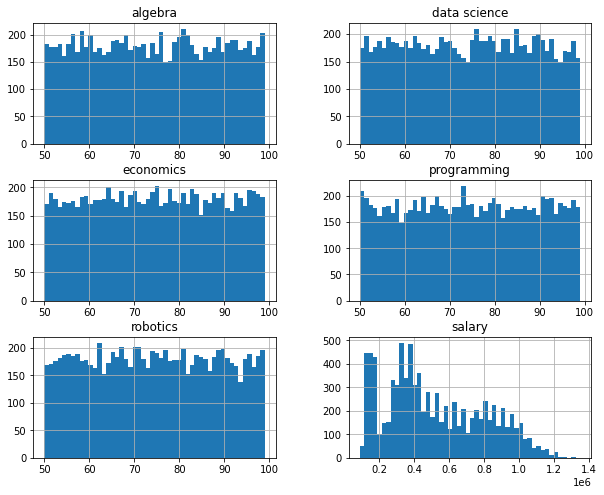

In [3]:
print(data.info())
print(data.job.value_counts())
print(data.describe())
data.hist(bins=50, figsize=(10, 8))
plt.show()

In [4]:
corr_matrix = data.corr()
print(corr_matrix['salary'].sort_values(ascending=False))

salary          1.000000
programming     0.153397
algebra         0.072278
data science    0.046113
robotics        0.040829
economics       0.013680
Name: salary, dtype: float64


In [5]:
#feature preparation
#normalize
data.loc[:,'algebra':'economics'] = data.loc[:,'algebra':'economics']/100

range_salary = data.salary.max() - data.salary.min()
min_salary = data.salary.min()
data.salary = (data.salary - data.salary.min())/(data.salary.max()-data.salary.min())

#categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_set = ColumnTransformer([('encoder', OneHotEncoder(),[5])], remainder='passthrough') 
onehot_data = pd.DataFrame(column_set.fit_transform(data)) 
onehot_data = onehot_data.astype(np.float64)

In [6]:
X, y = onehot_data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(lin_reg.score(X_train, y_train))
print(lin_reg.score(X_test, y_test))
preds = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
#score with linear regression: 0.9485370591354618, 0.9503881307035131

0.9480477256446682
0.9503881307035131
RMSE: 0.049630


In [8]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.95, learning_rate = 0.3,
                max_depth = 5, alpha = 1, n_estimators = 40)
xg_reg.fit(X_train,y_train)

print(xg_reg.score(X_train, y_train))
print(xg_reg.score(X_test, y_test))
#score with xgboosting: 0.9726619058152907, 0.9690720932762082
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[16:07:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.9726619058152907
0.9690720932762082
RMSE: 0.039186


In [9]:
params = params = {"objective":"reg:linear",'colsample_bytree': 0.95,'learning_rate': 0.3,
                'max_depth': 5, 'alpha': 1}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=4,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()
print((cv_results["test-rmse-mean"]).tail(1))
#k-means hasn't shown significant decrease in rmse

[16:07:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:07:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:07:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:07:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
49    0.040783
Name: test-rmse-mean, dtype: float64


In [ ]:
'''
means = [data[data['job'] == i]['salary'].mean() for i in data.job.unique()]
stds = [data[data['job'] == i]['salary'].std() for i in data.job.unique()]
print(stds)
bar_data = means
labels = list(data.job.unique())
plt.xticks(range(len(bar_data)), labels)
plt.bar(range(len(bar_data)), bar_data) 
plt.show()
'''

In [ ]:
'''data["ds_per_economics"] = data["data science"]/data["economics"]
data["prog_per_alg"] = data["programming"]/data["algebra"]
data["prog_per_econ"] = data["programming"]/data["economics"]
'''
#new features didn't increase performance

In [ ]:
'''
onehot_data['salary_cat'] = pd.cut(onehot_data[15], bins=[-0.1, 0.15, 0.4, 0.7, 1.1], labels=[1, 2, 3, 4])
onehot_data['salary_cat'].hist()
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(onehot_data, onehot_data["salary_cat"]):
    strat_train_set = onehot_data.loc[train_index]
    strat_test_set = onehot_data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop('salary_cat', axis=1, inplace=True)'''
#stratified shuffle didn't provide increase in performance